In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "PL_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

# Load Files

In [2]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_PL_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [3]:
len(windmill)

28

In [4]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [5]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [6]:
df = features.parallelize_extract(df)

parallelize_extract time:  1383.777233839035


In [7]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [8]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [9]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [10]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [11]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [12]:
df_train.to_parquet(constant.PL_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.PL_SC_EVL_path, index=False)

# Neural Network Train

In [13]:
df_train = pd.read_parquet(constant.PL_SC_TRAIN_path)

In [14]:
len(df_train)

244636

In [15]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=50
hidden_size = 1000
output_size = 1

## Original Features


In [16]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [17]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

In [18]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [19]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [20]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"original_model.pth")

Epoch 0 train loss: 0.03554443269968033
Epoch 10 train loss: 0.024047166109085083
Epoch 20 train loss: 0.02334856614470482
Epoch 30 train loss: 0.022569449618458748
Epoch 40 train loss: 0.02170415222644806


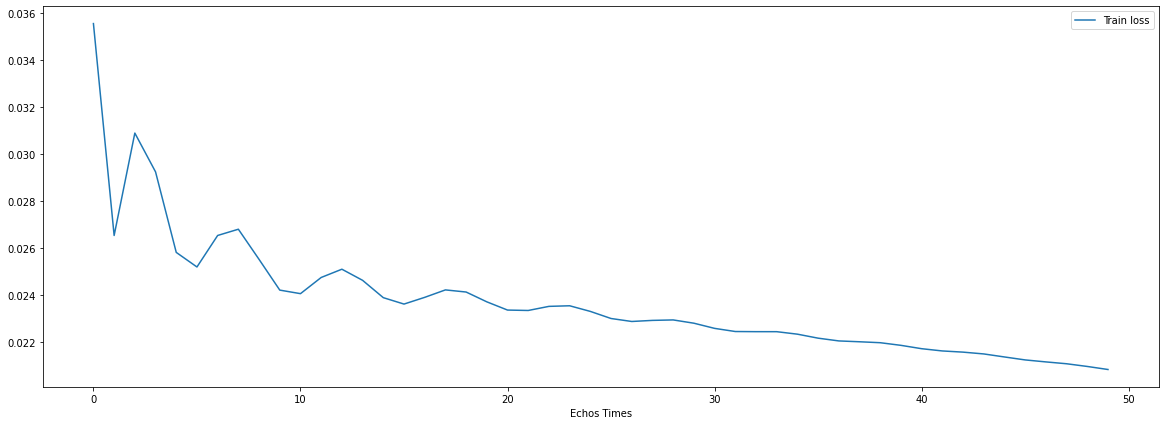

In [21]:
myplot.model_loss({"Train loss":train_hist_original}, path=plot_path+"original_loss.png")

## Windshear Features

In [22]:
model_wsr = MLP_Regression(
  input_size=44,
  hidden_size=hidden_size
)

In [23]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

In [24]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [25]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [26]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"wsr_model.pth")

Epoch 0 train loss: 0.037328992038965225
Epoch 10 train loss: 0.02086377516388893
Epoch 20 train loss: 0.01619437336921692
Epoch 30 train loss: 0.011956398375332355
Epoch 40 train loss: 0.009318418800830841


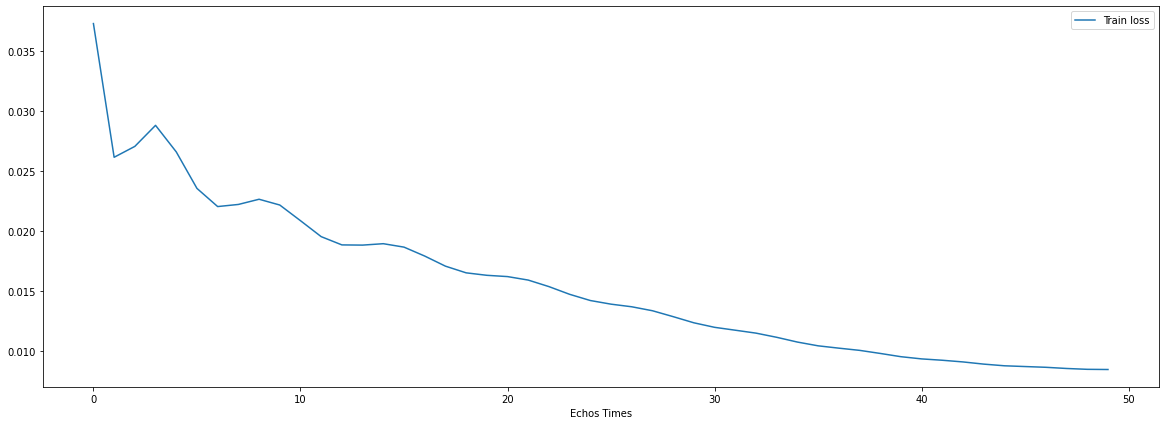

In [27]:
myplot.model_loss({"Train loss":train_hist_wsr}, path=plot_path+"wsr_loss.png")

## Geo Features

In [28]:
model_geo = MLP_Regression(
  input_size=46,
  hidden_size=hidden_size
)

In [29]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

In [30]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [31]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [32]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.04262332245707512
Epoch 10 train loss: 0.020854586735367775
Epoch 20 train loss: 0.016276877373456955
Epoch 30 train loss: 0.011946525424718857
Epoch 40 train loss: 0.00920904241502285


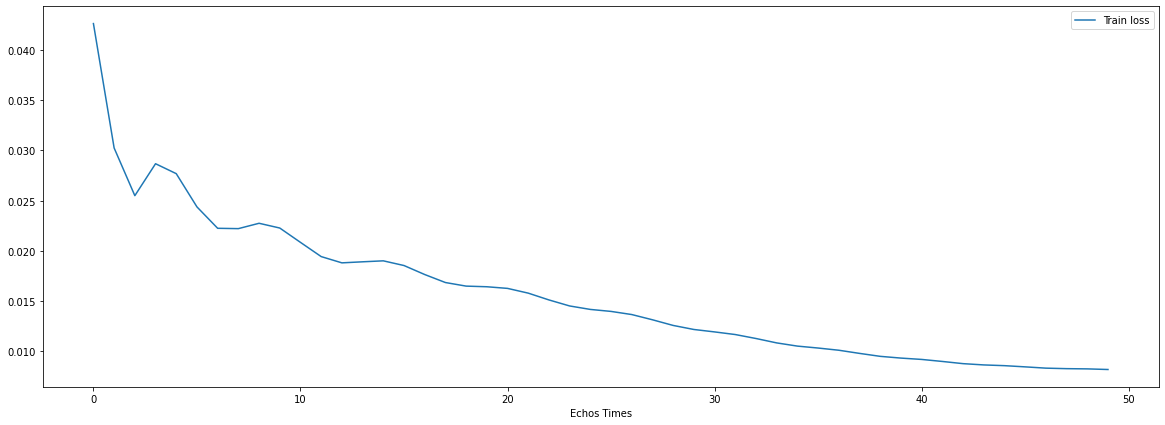

In [33]:
myplot.model_loss({"Train loss":train_hist_geo}, path=plot_path+"geo_loss.png")

## Semigeo Features

In [34]:
model_semigeo = MLP_Regression(
  input_size=47,
  hidden_size=1000
)

In [35]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

In [36]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [37]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [38]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.042298607528209686
Epoch 10 train loss: 0.02139456197619438
Epoch 20 train loss: 0.0167342908680439
Epoch 30 train loss: 0.012102455832064152
Epoch 40 train loss: 0.008967813104391098


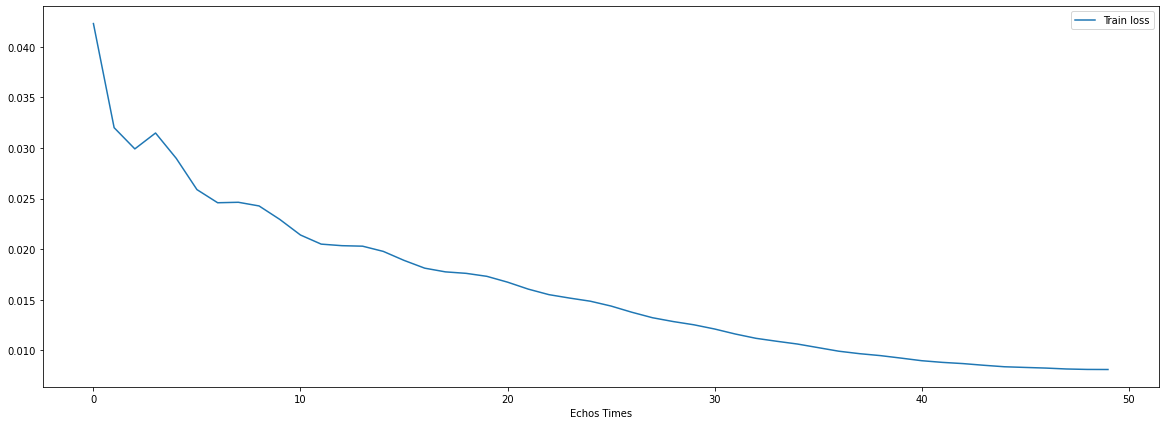

In [39]:
myplot.model_loss({"Train loss":train_hist_semigeo}, path=plot_path+"semigeo_loss.png")